![](https://www.ishn.com/ext/resources/Issues/2019/06-June/ISHN0619_C2_pic.jpg?1559575718)

# **Introduction and description of the data and the project**

This project's objective is to use a machine learning and data mining algorithms that predict whether a person in a given county is likely to have a specific infectious disease based on a data from a dataset from Kaggle called [Infectious Disease 2001-2004](https://www.kaggle.com/datasets/jahaidulislam/infectious-disease-2001-2014).

Infectious diseases, caused by pathogens like viruses, bacteria, fungi, and parasites, spread through various means including direct contact, droplets, airborne particles, and contaminated food or water. These diseases significantly impact public health and the global economy, with varying incidence and prevalence across different regions and populations over time.

The dataset tracks outbreaks by year and state, detailing the location, type, duration, and demographic information of affected individuals, such as age, gender, and race. It also includes information on the suspected or confirmed pathogens, modes of transmission, and outbreak sources, covering a range of diseases like foodborne illnesses, respiratory infections, and sexually transmitted infections.

Dataset Features:
*   Disease
*   County
*   Year
*   Sex
*   Count
*   Population
*   Rate
*   CI.lower
*   CI.upper
*   Unstable

<div align="center" style="font-size:14px;">
  <h1>Importing the needed libraries</h1>
</div>

In [37]:
# Loading of data
import pandas as pd
import numpy as np
pd.options.mode.copy_on_write = True # When performing certain operations on a pandas DataFrame, it may create copies of the data even if the operation does not actually modify the data. That's why we use this configuration option for the pandas library that helps manage how data is copied.

# Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns # aesthetics of plots
import seaborn as sns

# Data splitting
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Standardization 
from sklearn.preprocessing import StandardScaler, LabelEncoder


from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
import joblib

from collections import Counter

<div align="center" style="font-size:14px;">
  <h1>Loading of dataset</h1>
</div>

In [4]:
my_df = pd.read_csv('/kaggle/input/infectious-disease-2001-2014/Infectious Disease 2001-2014.csv')
my_df.head()


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,Total,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,Female,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,Male,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,Total,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,Female,145,17555714,0.826,0.697,0.972,


<div align="center" style="font-size:14px;">
  <h1>Data analysis and visualization</h1>
</div>

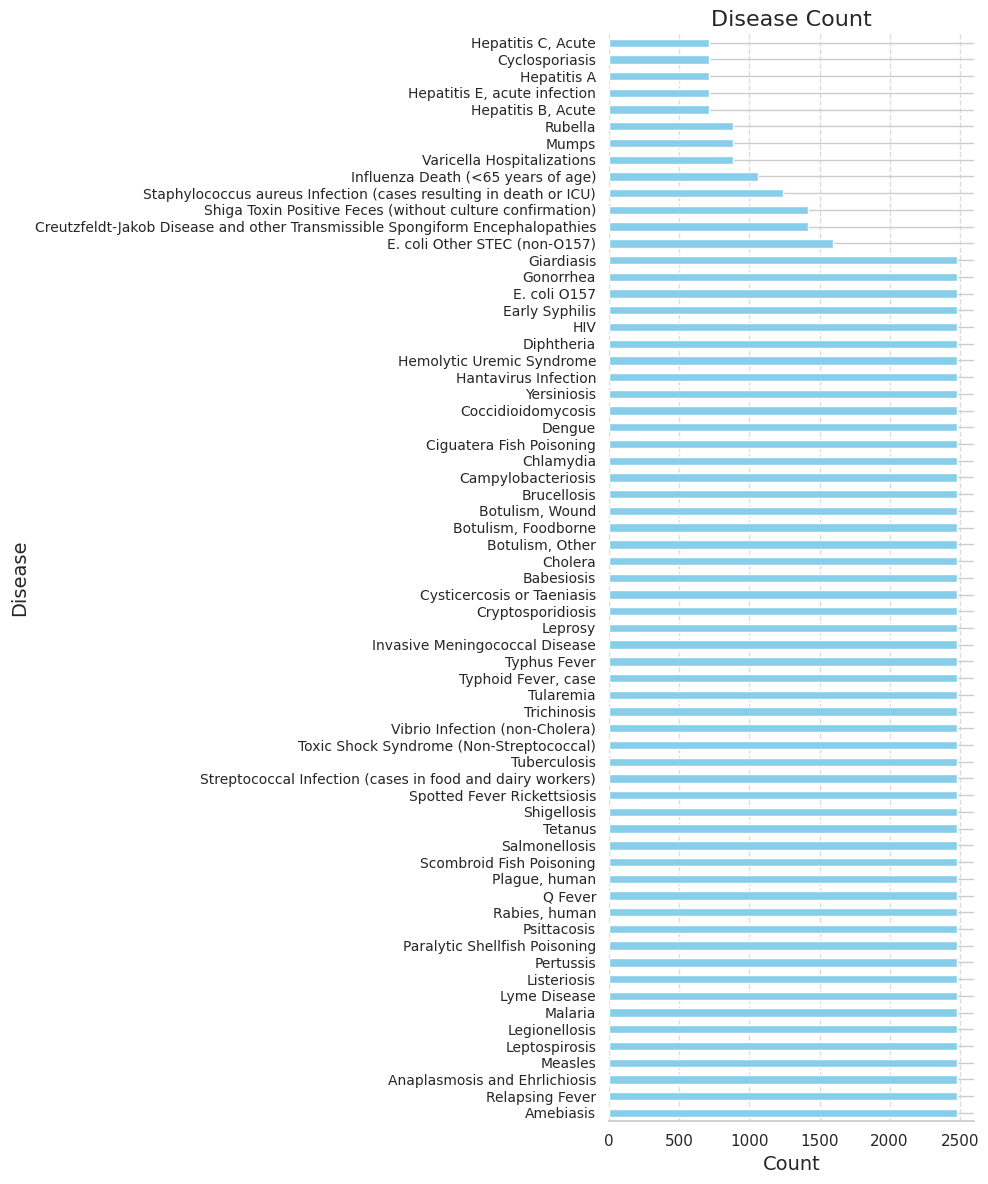

In [5]:
# my_df['Disease'].value_counts().plot(kind='barh')
# plt.xlabel('Count')
# plt.ylabel('Disease')
# plt.title('Disease Count')
# plt.show()


# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 12))
my_df['Disease'].value_counts().plot(kind='barh', color='skyblue')

# Add labels and title
plt.xlabel('Count', fontsize=14)
plt.ylabel('Disease', fontsize=14)
plt.title('Disease Count', fontsize=16)

# Rotate y-axis labels for better readability
plt.yticks(fontsize=10)

# Add grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Remove frame to make it cleaner
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()

In [4]:
my_df.describe()

,Year,Count,Population,Rate,CI.lower,CI.upper
count,141777.000000,141777.000000,1.417770e+05,141777.000000,141777.000000,141777.000000
mean,2007.857678,81.368438,8.299702e+05,6.984715,5.726249,28.912777
std,4.052999,1954.637660,3.452198e+06,44.861027,41.479404,87.209601
min,2001.000000,0.000000,5.330000e+02,0.000000,0.000000,0.010000
25%,2004.000000,0.000000,2.871500e+04,0.000000,0.000000,1.495000
50%,2008.000000,0.000000,1.239460e+05,0.000000,0.000000,5.233000
75%,2011.000000,1.000000,4.119620e+05,0.203000,0.010000,17.814000
max,2014.000000,174557.000000,3.850149e+07,1020.550000,992.007000,1632.966000


Column: Disease, Type: object
Skipping non-numeric column: Disease
Column: County, Type: object
Skipping non-numeric column: County
Column: Year, Type: int64


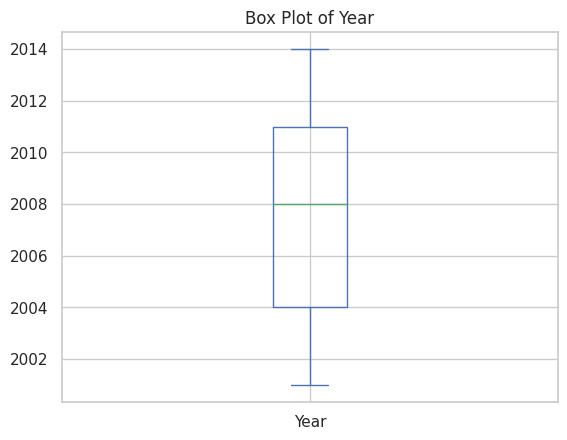

Column: Sex, Type: object
Skipping non-numeric column: Sex
Column: Count, Type: int64


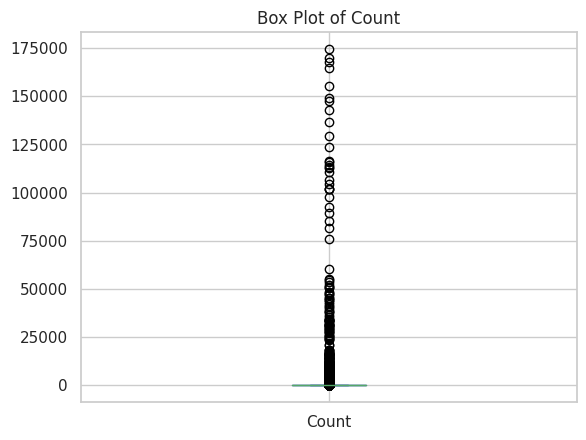

Column: Population, Type: int64


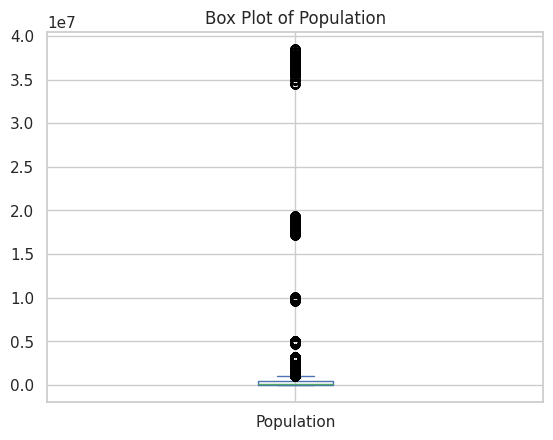

Column: Rate, Type: float64


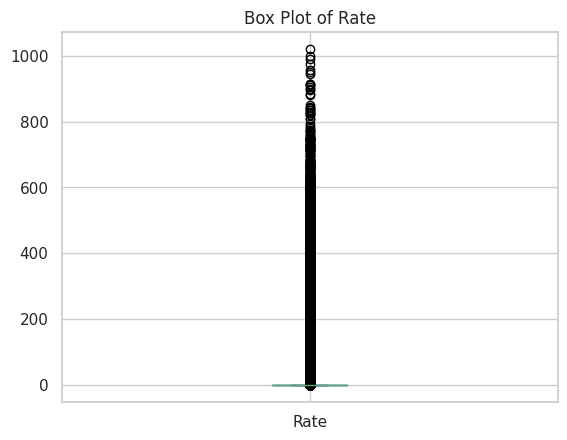

Column: CI.lower, Type: float64


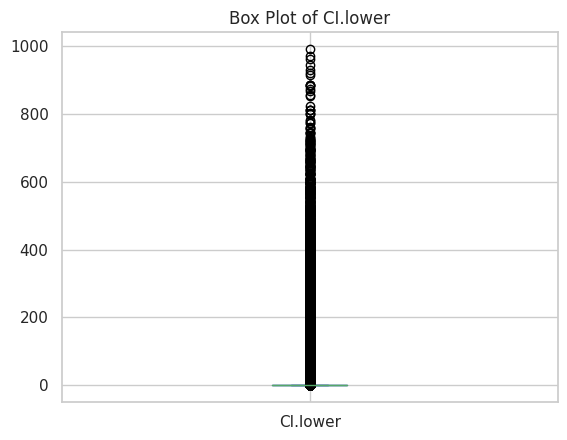

Column: CI.upper, Type: float64


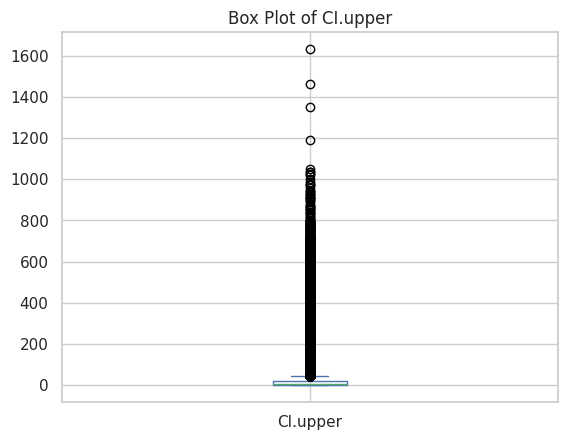

In [6]:
for col in my_df.columns[0:-1]:
    # Print column name and type
    print(f"Column: {col}, Type: {my_df[col].dtype}")
    # Check if the column is numeric
    if pd.api.types.is_numeric_dtype(my_df[col]):
        my_df[col].plot.box(title=f"Box Plot of {col}")
        plt.show()
    else:
        print(f"Skipping non-numeric column: {col}")

<p style="font-size:14px;">
In the obtained box plots we can see that there are a lot of outliers (in all of them, except the box plot for the column "Year"). We have to decide what should we do with them and understand if they are important for our problem solving or not. We will use <strong>log transformation</strong>.
</p>

In [7]:
def log_transform_outliers(series):
    # Define threshold for outliers (e.g., 1.5 times IQR)
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    threshold = Q3 + 1.5 * IQR

    # Apply log transformation to outliers
    return series.apply(lambda x: np.log(x) if x > threshold else x)

# Create a new DataFrame for transformed data
my_df_transformed = pd.DataFrame()

# Apply log transformation to all numeric columns
for col in my_df.select_dtypes(include=np.number):
    my_df_transformed[f'{col}_transformed'] = log_transform_outliers(my_df[col])

print("\nTransformed Dataset:")
print(my_df_transformed.head())



Transformed Dataset:
   Year_transformed  Count_transformed  Population_transformed  \
0              2001           6.347389               17.356898   
1              2001           5.170484               16.668569   
2              2001           5.899897               16.658909   
3              2002           6.091310               17.369152   
4              2002           4.976734               16.680890   

   Rate_transformed  CI.lower_transformed  CI.upper_transformed  
0          0.503197              0.419368                 1.796  
1          0.014889             -0.138113                 1.176  
2          0.753772              0.648673                 2.355  
3          0.235072              0.139762                 1.389  
4         -0.191161             -0.360970                 0.972  


Year_transformed             Axes(0.125,0.712609;0.227941x0.167391)
Count_transformed         Axes(0.398529,0.712609;0.227941x0.167391)
Population_transformed    Axes(0.672059,0.712609;0.227941x0.167391)
Rate_transformed             Axes(0.125,0.511739;0.227941x0.167391)
CI.lower_transformed      Axes(0.398529,0.511739;0.227941x0.167391)
CI.upper_transformed      Axes(0.672059,0.511739;0.227941x0.167391)
dtype: object

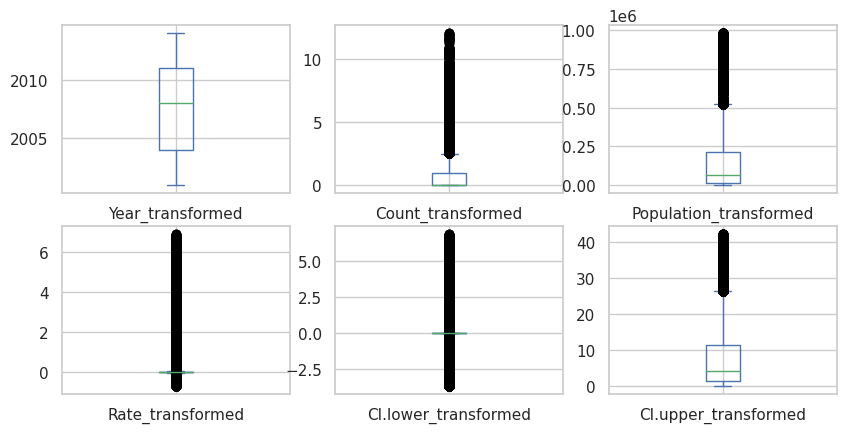

In [9]:
my_df_transformed.plot(kind='box', subplots=True, layout=(4,3), sharex=False, figsize=(10, 10))


We can see that we have some improvement and we can proceed with working on the data.
Next, we check if there are NA values and if yes, we delete them.

In [ ]:
my_df.isna().sum()

We see that we don't have NA values, so we proceed with the model selection.

<div align="center" style="font-size:14px;">
  <h1>Data splitting and model selection</h1>
</div>

In [8]:
# Encode categorical variables
my_df_encoded = my_df.copy()
le = LabelEncoder()
my_df_encoded['Sex'] = le.fit_transform(my_df['Sex'])
my_df_encoded.head()


,Disease,County,Year,Sex,Count,Population,Rate,CI.lower,CI.upper,Unstable
0,Amebiasis,California,2001,2,571,34514777,1.654,1.521,1.796,
1,Amebiasis,California,2001,0,176,17340743,1.015,0.871,1.176,
2,Amebiasis,California,2001,1,365,17174034,2.125,1.913,2.355,
3,Amebiasis,California,2002,2,442,34940334,1.265,1.150,1.389,
4,Amebiasis,California,2002,0,145,17555714,0.826,0.697,0.972,


<div align="center" style="font-size:14px;">
  <h2>K-means clustering</h2>
</div>

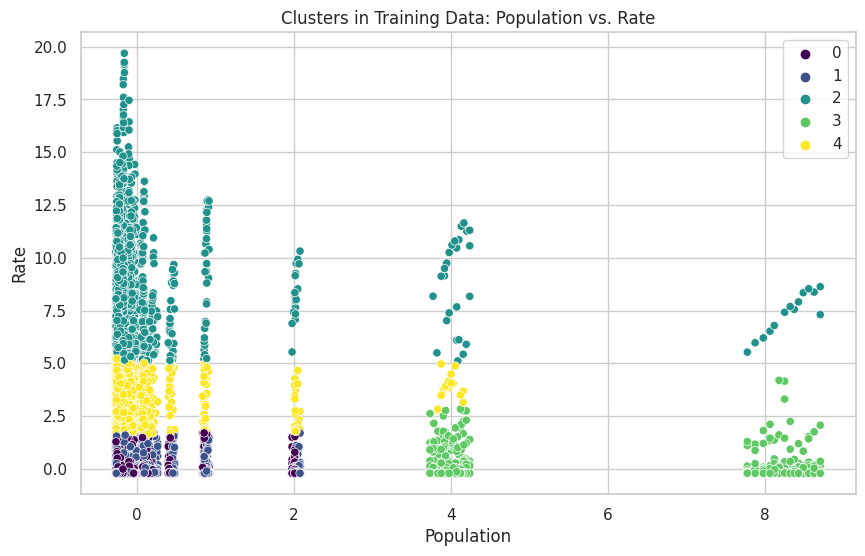

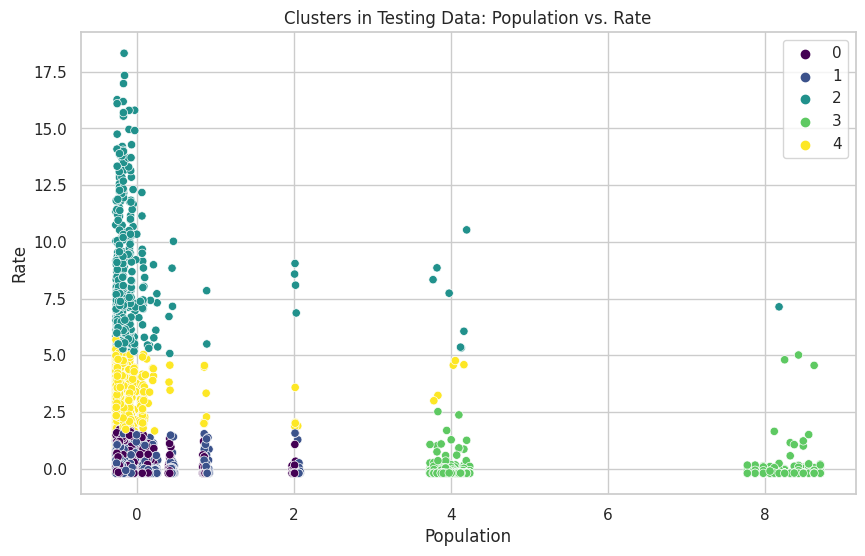

In [9]:
# Feature matrix and target variable
X = my_df_encoded[['Year', 'Sex', 'Population', 'Rate', 'CI.lower', 'CI.upper']]
y = my_df_encoded['Count'] > 0  # Binary target: 1 if Count > 0, else 0

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=np.random)

# Standardizing the features
numeric_features = ['Year', 'Population', 'Rate', 'CI.lower', 'CI.upper']
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_scaled[numeric_features] = scaler.transform(X_test[numeric_features])

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
train_clusters = kmeans.fit_predict(X_train_scaled[numeric_features])
test_clusters = kmeans.predict(X_test_scaled[numeric_features])

# Add cluster labels to DataFrames
X_train_scaled['Cluster'] = train_clusters
X_test_scaled['Cluster'] = test_clusters

# Visualize the Clusters with a Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_scaled['Population'], y=X_train_scaled['Rate'], hue=X_train_scaled['Cluster'], palette='viridis')
plt.title('Clusters in Training Data: Population vs. Rate')
plt.xlabel('Population')
plt.ylabel('Rate')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_scaled['Population'], y=X_test_scaled['Rate'], hue=X_test_scaled['Cluster'], palette='viridis')
plt.title('Clusters in Testing Data: Population vs. Rate')
plt.xlabel('Population')
plt.ylabel('Rate')
plt.legend()
plt.show()


<div align="center" style="font-size:14px;">
  <h2>Decision trees</h2>
</div>

Decision Tree Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20129
        True       1.00      1.00      1.00     20286

    accuracy                           1.00     40415
   macro avg       1.00      1.00      1.00     40415
weighted avg       1.00      1.00      1.00     40415

Confusion Matrix:
[[20129     0]
 [    0 20286]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


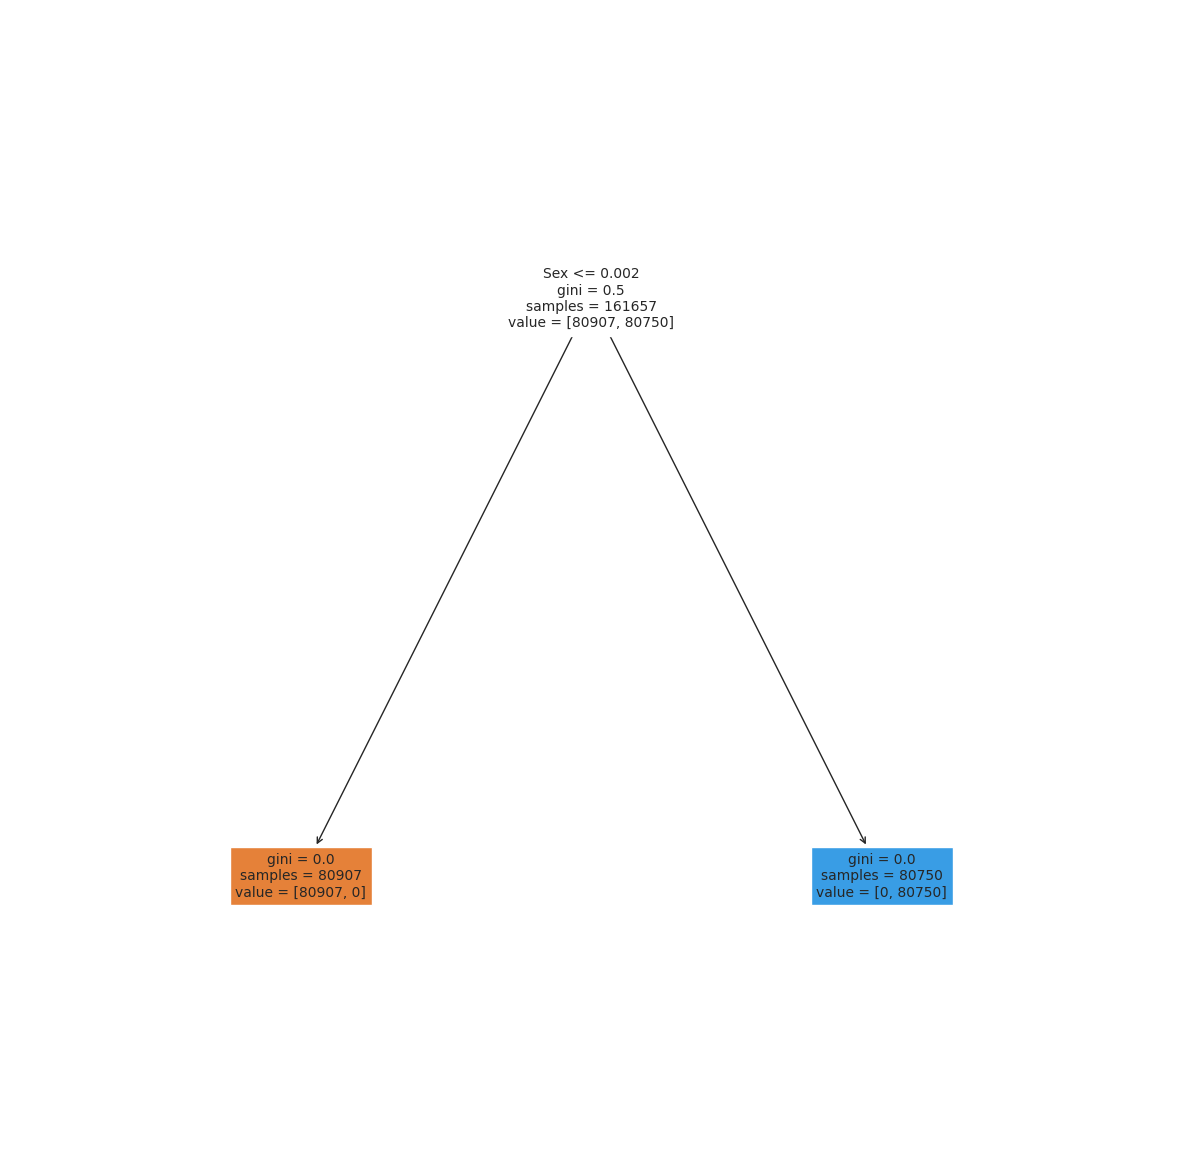

In [11]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

# Evaluate the model
print("Decision Tree Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross Validation
cross_val_acc = cross_val_score(decision_tree, X_res, y_res, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))

# Plotting the Decision Tree
plt.figure("Decision Tree Classifier", figsize=[15,15])
plot_tree(decision_tree, filled=True, feature_names=my_df_encoded.columns, fontsize=10)
plt.show()


<div align="center" style="font-size:14px;">
  <h2>Logistic regression</h2>
</div>

In [27]:
logistic_regression = LogisticRegression(random_state=42, max_iter=1000)
logistic_regression.fit(X_train, y_train)
y_pred = logistic_regression.predict(X_test)

# Evaluate the model
print("Logistic Regression")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross Validation
cross_val_acc = cross_val_score(logistic_regression, X_res, y_res, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))

Logistic Regression
Classification Report:
              precision    recall  f1-score   support

       False       0.58      0.88      0.70     20129
        True       0.76      0.37      0.49     20286

    accuracy                           0.62     40415
   macro avg       0.67      0.62      0.60     40415
weighted avg       0.67      0.62      0.60     40415

Confusion Matrix:
[[17793  2336]
 [12871  7415]]
Accuracy: 0.6237288135593221
Cross Validation Accuracy: 62.26%


<div align="center" style="font-size:14px;">
  <h2>Random Forest Classification</h2>
</div>

In [31]:
# Train Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

# Evaluate the model
print("Random Forest Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross Validation
cross_val_acc = cross_val_score(random_forest, X_res, y_res, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))


Random Forest Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20129
        True       1.00      1.00      1.00     20286

    accuracy                           1.00     40415
   macro avg       1.00      1.00      1.00     40415
weighted avg       1.00      1.00      1.00     40415

Confusion Matrix:
[[20129     0]
 [    0 20286]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


<div align="center" style="font-size:14px;">
  <h2>Gradient Boosting Classification</h2>
</div>

In [32]:
# Train Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)
y_pred = gradient_boosting.predict(X_test)

# Evaluate the model
print("Gradient Boosting Classifier")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Cross Validation
cross_val_acc = cross_val_score(gradient_boosting, X_res, y_res, cv=10, scoring='accuracy')
print("Cross Validation Accuracy: %.2f%%" % (cross_val_acc.mean() * 100))

Gradient Boosting Classifier
Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     20129
        True       1.00      1.00      1.00     20286

    accuracy                           1.00     40415
   macro avg       1.00      1.00      1.00     40415
weighted avg       1.00      1.00      1.00     40415

Confusion Matrix:
[[20129     0]
 [    0 20286]]
Accuracy: 1.0
Cross Validation Accuracy: 100.00%


In [56]:
# Aggregating Predictions
y_pred_dtc = decision_tree.predict(X_test)
y_pred_lr = logistic_regression.predict(X_test)
y_pred_rfc = random_forest.predict(X_test)

# Combine predictions into a single DataFrame
predictions = pd.DataFrame({
    'dtc': y_pred_dtc,
    'lr': y_pred_lr,
    'rfc': y_pred_rfc
})

most_frequent_disease = predictions.mode(axis=1)[0].mode()[0]
# Find the most frequent predicted county index
most_frequent_county_index = predictions['dtc'].value_counts().idxmax()

# Locate the most frequent county name using the index
most_frequent_county = my_df_encoded.loc[X_test.iloc[most_frequent_county_index].index, 'County'].mode()[0]


print(f"The most frequent predicted disease is: {most_frequent_disease}")
print(f"The most frequent predicted country is: {most_frequent_country}")

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.